## Stacking and Blending
Stacked Generalization or “Stacking” for short is an ensemble machine learning algorithm.It involves combining the predictions from multiple machine learning odels on the same dataset, like bagging and boosting.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We will build our bagging model on the {doc}`tips </content/appendix/data>` dataset from `scikit-learn`. The hidden code cell below loads that data and does a train-test split.

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In this exercise you'll work with the [Wisconsin Breast Cancer Dataset](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data) from the UCI machine learning repository. You'll predict whether a tumor is malignant or benign based on all the features.

In [3]:
wbc = pd.read_csv('/gdrive/MyDrive/datasets/data.csv')
wbc.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
X = wbc.drop(['diagnosis','Unnamed: 32'],axis=1)
y = wbc['diagnosis']
y = y.map({'M':1, 'B':0})

In [5]:
# evaluate bagging algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score

### Compare the base model performance

In [6]:
# get a list of models to evaluate
def get_models():
 models = dict()
 models['lr'] = LogisticRegression()
 models['knn'] = KNeighborsClassifier()
 models['dt'] = DecisionTreeClassifier()
 models['bayes'] = GaussianNB()
 return models

In [7]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
 return scores

In [8]:
models = get_models()
results = pd.DataFrame()
# evaluate the models and store results
# results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X, y)
 results[name] = scores
 print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>lr 0.610 (0.064)
>knn 0.766 (0.044)
>dt 0.937 (0.033)
>bayes 0.624 (0.017)


<Axes: >

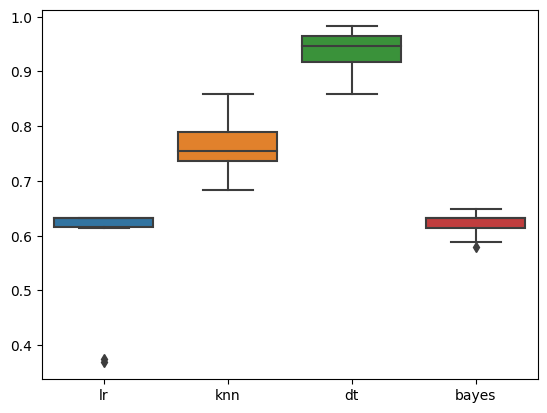

In [9]:
sns.boxplot(results)

### Train a stacked model

In [10]:
# get a stacking ensemble of models
def get_stacking():
 # define the base models
 base_models = list()
 base_models.append(('lr', LogisticRegression()))
 base_models.append(('knn', KNeighborsClassifier()))
 base_models.append(('decision_tree', DecisionTreeClassifier()))
 base_models.append(('bayes', GaussianNB()))
 # define meta learner model
 meta_model = LogisticRegression()
 # define the stacking ensemble
 model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=10)
 return model

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [12]:
stacked_model = get_stacking().fit(X_train,y_train)

### Use the stacked model to make predictions

In [13]:
stacked_model.predict(X_test[:100])

array([0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0])

In [14]:
accuracy_score(stacked_model.predict(X_test),y_test)

0.9473684210526315

### Stacked model along with base signals

 Get a stacking ensemble of models with base signals to the
 meta model  for this we set the passthrough argument to true

In [15]:
def get_stacking_with_base_signals():
 # define the base models
 base_models = list()
 base_models.append(('lr', LogisticRegression()))
 base_models.append(('knn', KNeighborsClassifier()))
 base_models.append(('decision_tree', DecisionTreeClassifier()))
 base_models.append(('bayes', GaussianNB()))
 # define meta learner model
 meta_model = LogisticRegression()
 # define the stacking ensemble
 model = StackingClassifier(estimators=base_models, final_estimator=meta_model, passthrough=True, cv=10)
 return model

In [16]:
stacked_model_with_base_signals = get_stacking_with_base_signals().fit(X_train,y_train)

In [17]:
accuracy_score(stacked_model_with_base_signals.predict(X_test),y_test)

0.631578947368421

In this case we saw a drop in accuracy by providing the meta model with base model signals as well.

### Compare the performance of the stacked model

In [18]:
def evaluate_model(model, X, y):
 cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
 return scores

In [19]:
# get a list of models to evaluate
def get_all_models():
 models = dict()
 models['lr'] = LogisticRegression()
 models['knn'] = KNeighborsClassifier()
 models['dt'] = DecisionTreeClassifier()
 models['bayes'] = GaussianNB()
 models['stacked'] = get_stacking()
 models['stacked_w_base'] = get_stacking_with_base_signals()
 return models

>lr 0.609 (0.085)
>knn 0.767 (0.055)
>dt 0.929 (0.028)
>bayes 0.626 (0.057)
>stacked 0.930 (0.029)
>stacked_w_base 0.609 (0.085)


<Axes: >

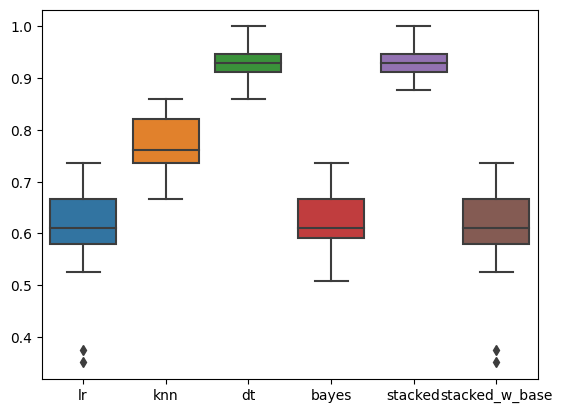

In [20]:
models = get_all_models()
# evaluate the models and store results
results = pd.DataFrame()
for name, model in models.items():
 scores = evaluate_model(model, X, y)
 results[name] = scores
 print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
sns.boxplot(results)

The stacked model outperforms the best model.